In [4]:
import pandas as pd
df = pd.read_csv('data/1003.csv')
df.head()

,timestamp,room_id,co2,temperature,humidity
0,2022-11-16 15:30:02+00:00,37239,1371,19.6,48
1,2022-11-16 15:32:02+00:00,37239,1367,19.6,48
2,2022-11-16 15:34:02+00:00,37239,1390,19.6,48
3,2022-11-16 15:36:02+00:00,37239,1384,19.6,48
4,2022-11-16 15:38:02+00:00,37239,1377,19.6,48


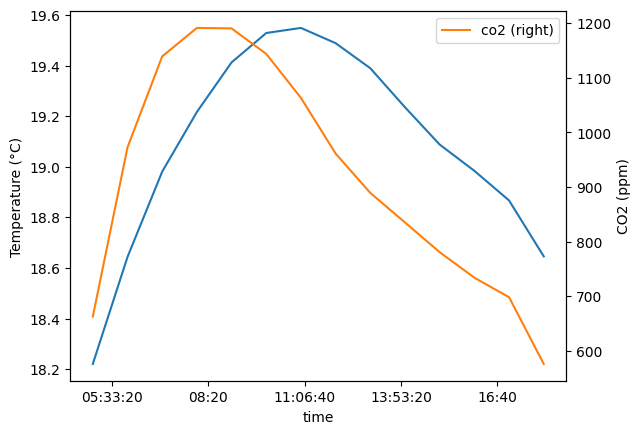

In [53]:
import matplotlib.pyplot as plt
df_30 = df.copy()
df_30.drop('room_id', axis=1, inplace=True)

df_30['timestamp'] = pd.to_datetime(df_30['timestamp'])
df_30.set_index('timestamp', inplace=True)

df_30 = df_30.between_time('5:00', '18:00')

df_30['time'] = df_30.index.time
df_30['time'] = df_30['time'].apply(lambda x: x.replace(minute=0,second=0, microsecond=0))

df_30 = df_30.groupby(['time']).mean()


#plot with legend

df_30['temperature'].plot()
plt.ylabel('Temperature (°C)')
plt.xlabel('Time')

df_30['co2'].plot(secondary_y=True)

plt.legend()

plt.ylabel('CO2 (ppm)')
plt.xlabel('Time')

plt.show()